In [1]:
!hostname

chinook04.rcs.alaska.edu


In [1]:
import pandas as pd 
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import geopandas as gpd
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [27]:
winter_months = [11, 12, 1, 2, 3]

RICK THOMAN
-

In [28]:
#Rick thoman data 
#https://docs.google.com/spreadsheets/d/1MUeq6N2F8OGBeYOa226iCbaVQBOxj01ibf5IwYqt5nI/edit?gid=0#gid=0
url = "https://docs.google.com/spreadsheets/d/1MUeq6N2F8OGBeYOa226iCbaVQBOxj01ibf5IwYqt5nI/export?format=csv&id=1MUeq6N2F8OGBeYOa226iCbaVQBOxj01ibf5IwYqt5nI&gid=0"
rick_df = pd.read_csv(url)

rick_df['Year'] = pd.to_numeric(rick_df['Year'], errors='coerce')
rick_df['Month'] = pd.to_numeric(rick_df['Month'], errors='coerce')
rick_df['Rain Precip Amount (mm)'] = pd.to_numeric(rick_df['Rain Precip Amount (mm)'],errors='coerce')

rick_season_df = rick_df.loc[rick_df['Month'].isin([11, 12, 1, 2, 3])].copy()
season_start = rick_season_df['Year'].where(~rick_season_df['Month'].isin([1, 2, 3]),rick_season_df['Year'] - 1)
season_end = season_start + 1

rick_season_df['season'] = (season_start.astype(int).astype(str)+ '-'+ season_end.astype(int).astype(str))
rick_season_df['season_sum_rain_mm'] = (rick_season_df.groupby('season')['Rain Precip Amount (mm)'].transform('sum'))

rick_monthly = rick_season_df.groupby('Month')['Rain Precip Amount (mm)'].sum(numeric_only=True)
rick_monthly=rick_monthly.reindex(winter_months).values #correct order 

Alaska Shapefiles 
-

In [29]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

ASOS 
-

In [30]:
website='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PAFA&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1949&month1=10&day1=1&year2=2022&month2=12&day2=23&tz=Etc%2FUTC&format=onlycomma&latlon=yes&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'
#https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PAFA&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1950&month1=1&day1=1&year2=2023&month2=12&day2=9&tz=America%2FAnchorage&format=onlycomma&latlon=yes&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'
response = requests.get(website)
if response.status_code == 200:
    data = io.StringIO(response.text)
    df = pd.read_csv(data, comment="#")  
    print(df.head())
else:
    print("Error:", response.status_code)

  station             valid       lon      lat  tmpc p01m wxcodes snowdepth
0    PAFA  1949-10-01 00:00 -147.8761  64.8039  6.67    M       M         M
1    PAFA  1949-10-01 01:00 -147.8761  64.8039  6.67    M       M         M
2    PAFA  1949-10-01 02:00 -147.8761  64.8039  6.11    M       M         M
3    PAFA  1949-10-01 03:00 -147.8761  64.8039  6.11    M       M         M
4    PAFA  1949-10-01 04:00 -147.8761  64.8039  5.00    M       M         M


In [31]:
df['valid'] = pd.to_datetime(df['valid'])
df['month'] = df['valid'].dt.month
df['date'] = df['valid'].dt.date
df['time'] = df['valid'].dt.time
#df['tmpc']
#df = df.drop(columns=['column_name'])
winter_df = df[df['month'].isin([11, 12, 1, 2, 3])] #filter to only keep the ROS months 

winter_df['date'] = pd.to_datetime(winter_df['date'])
year = winter_df['date'].dt.year
month = winter_df['date'].dt.month
season_start = year.where(~month.isin([1, 2, 3]), year - 1)
season_end = season_start + 1
winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)

#filter to only when RA is present 
mask = winter_df['wxcodes'].str.contains('RA', na=False)
rain_and_mixed_df = winter_df[mask]
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('M', np.nan) 
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('T', np.nan) 
rain_and_mixed_df['p01m'] = pd.to_numeric(rain_and_mixed_df['p01m'], errors='coerce')

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2064244/854007281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['date'] = pd.to_datetime(winter_df['date'])
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2064244/854007281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2064244/854007281.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [32]:
seasonal_sum_rain_and_mixed_df = (rain_and_mixed_df.groupby('season')['p01m'].sum()) #seasonal value adding station data up 
monthly_sum_by_season_ASOS = (rain_and_mixed_df.groupby(['season', 'month'])['p01m'].sum().unstack('month')) # monthly sums also per season 
monthly_sum_ASOS = monthly_sum_by_season_ASOS.sum(axis=0)
monthly_sum_ASOS=monthly_sum_ASOS.reindex(winter_months).values 

monthly_mean_by_season_ASOS = (rain_and_mixed_df.groupby(['season', 'month'])['p01m'].mean().unstack('month'))

start_years = seasonal_sum_rain_and_mixed_df.index.str.slice(0, 4).astype(int)
all_seasons = [f"{y}-{y+1}" for y in range(start_years.min(), start_years.max() + 1)]

seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.reindex(all_seasons)
seasonal_sum_rain_and_mixed_df=seasonal_sum_rain_and_mixed_df.fillna(0)
seasons_seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.index.tolist()

#Rain only, no other precip, not realistic max of 2mm 
'''
mask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA
rain_only_df = winter_df[mask]
rain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)
rain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)

seasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())
#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()
seasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)
seasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)
seasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()
'''

"\nmask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA\nrain_only_df = winter_df[mask]\nrain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)\nrain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)\n\nseasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())\n#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()\nseasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)\nseasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)\nseasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()\n"

In [33]:
monthly_sum_by_season_ASOS

#rain_and_mixed_df['p01m']
monthlysu_allmonths=rain_and_mixed_df.groupby('month')['p01m'].sum()
monthly_order = [11, 12, 1, 2, 3]
sum_order= monthlysu_allmonths.loc[monthly_order]
sum_order

month
11    46.84
12    48.98
1     14.94
2     13.93
3     12.66
Name: p01m, dtype: float64

Combining the seasons from Rick with the total dataset from era5
-

In [34]:
# Make a DataFrame with ALL seasons
full_seasons_df = pd.DataFrame({'season': seasons_seasonal_sum_rain_and_mixed_df})
# Merge with  rick data, keeping ALL seasons
rick_season_full_df = full_seasons_df.merge(rick_season_df[['season', 'season_sum_rain_mm']],on='season',how='left')


Plotting
-

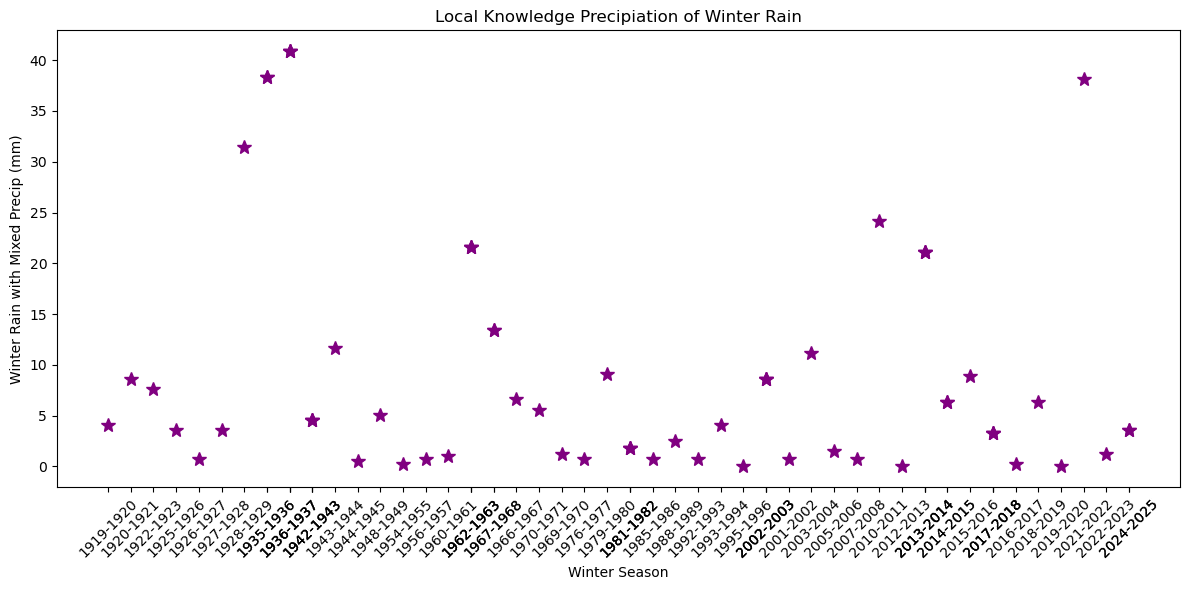

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(rick_season_df['season'],rick_season_df['season_sum_rain_mm'], marker='*',markersize=10, linestyle='', color='purple')
plt.title('Local Knowledge Precipiation of Winter Rain')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain with Mixed Precip (mm)')
plt.xticks(ticks=rick_season_df['season'], labels=rick_season_df['season'], rotation=45)
plt.tight_layout()
plt.show()

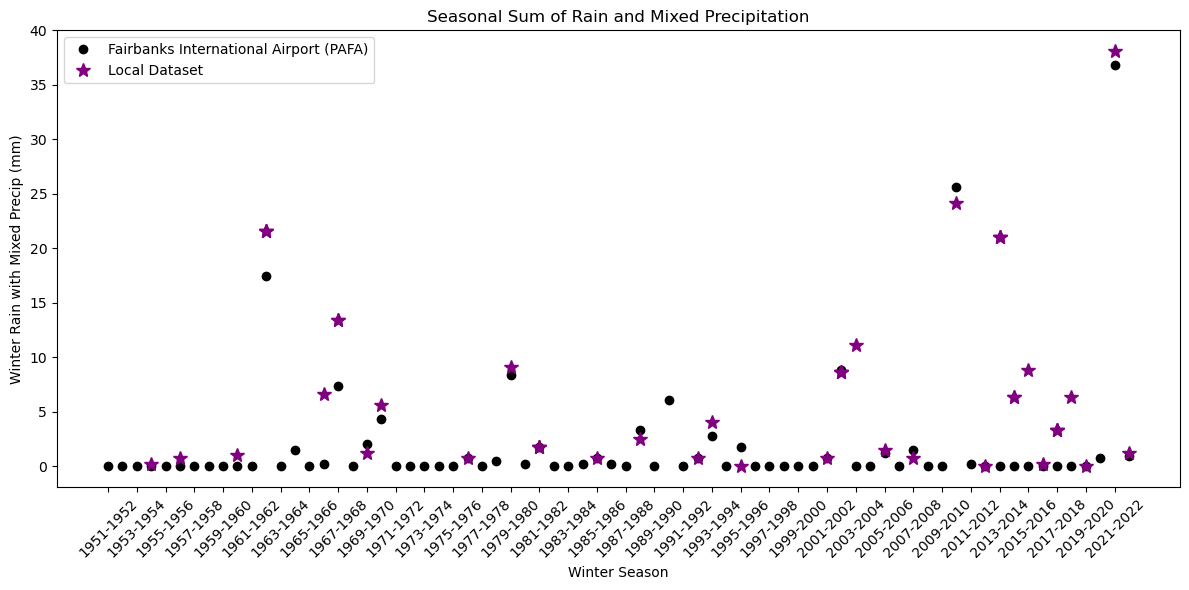

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, marker='o', linestyle='', color='black',label='Fairbanks International Airport (PAFA)')
plt.plot(rick_season_full_df['season'],rick_season_full_df['season_sum_rain_mm'], marker='*',markersize=10, linestyle='', color='purple',label='Local Dataset')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Sum of Rain and Mixed Precipitation')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain with Mixed Precip (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2), labels=seasons_seasonal_sum_rain_and_mixed_df[::2], rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

To Compare PAFA, DYN and RAW
-


In [37]:
pafa_lat=64.8039
pafa_lon=-147.8761

In [ ]:
def getXY(lat, lon, dataarray):
    abslat = np.abs(dataarray.XLAT-lat)
    abslon = np.abs(dataarray.XLONG-lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

def getXY_latlon(lat, lon, dataarray):
    abslat = np.abs(dataarray.latitude - lat)
    abslon = np.abs(dataarray.longitude - lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

: 

In [ ]:
regridded_era5_path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ERA5_31kmto4km_nearest_regridded.nc'
regridded_era5=xr.open_dataset(regridded_era5_path)

#ERA5  4km
era5_4km='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ROS_Monthly_*.nc'
era5_4km = xr.open_mfdataset(era5_4km,combine="by_coords", parallel=True)


In [ ]:
x_idx, y_idx = getXY(pafa_lat, pafa_lon, regridded_era5)
nearest_lat = regridded_era5.XLAT[y_idx, x_idx]
nearest_lon = regridded_era5.XLONG[y_idx, x_idx]


In [ ]:
cell = era5_4km.isel(
    south_north=y_idx,
    west_east=x_idx
)

In [ ]:
era5_4km_rain_sum_at_site = era5_4km['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='season')

era5_regridded_31km_rain_sum_at_site = regridded_era5['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='season')

seasons=era5_4km['season']

In [ ]:
#era5_4km_rain_sum_at_site = era5_4km['rain_ros_sum'].isel(south_north=nearest_lat,west_east=nearest_lon)

#seasonal_rain_sum_era5_rain_sum_at_site=era5_4km_rain_sum_at_site.sum(dim='month')
#season_era5_4km=era5_4km['season']
#monthly_rain_sum_era5_rain_sum_at_site=era5_4km_rain_sum_at_site.sum(dim='season')

In [ ]:
#ERA5 31km RAW
'''raw_era5_path='/center1/DYNDOWN/phutton5/ROS/Raw_ERA5/Raw_ERA5_netcdf/Raw_ERA5_ROS_Monthly_*'
raw_era5 = sorted(glob.glob(raw_era5_path))
raw_era5 = xr.open_mfdataset(raw_era5,combine="by_coords",parallel=True)

raw_rain_sum_at_site = raw_era5['rain_ros_sum'].sel(
    latitude=pafa_lat,
    longitude=pafa_lon,
    method='nearest')
'''

#ERA5  4km
'''era5_4km='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ROS_Monthly_*.nc'
era5_4km = xr.open_mfdataset(era5_4km,combine="by_coords", parallel=True)

lat_diff = np.abs(era5_4km.XLAT - pafa_lat)
lon_diff = np.abs(era5_4km.XLONG - pafa_lon)
i_south_north, i_west_east = np.unravel_index((lat_diff + lon_diff).argmin(), lat_diff.shape)
era5_4km_rain_sum_at_site = era5_4km['rain_ros_sum'].isel(south_north=i_south_north,west_east=i_west_east)

#seasonal_rain_sum_era5_rain_sum_at_site=era5_4km_rain_sum_at_site.sum(dim='month')
#season_era5_4km=era5_4km['season']
#monthly_rain_sum_era5_rain_sum_at_site=era5_4km_rain_sum_at_site.sum(dim='season')
'''

#ERA5 4km regridded to 31km 
'''
regridded_NEAREST='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/NEAREST_REGRIDDED_ERA5_4km_ROS.nc'
era5_4km_regridded_nearest = xr.open_mfdataset(regridded_NEAREST,combine="by_coords",parallel=True)
era5_4km_regridded_nearest_lat,era5_4km_regridded_nearest_long=getXY_latlon(raw_era5['latitude'],raw_era5['longitude'],era5_4km_regridded_nearest)

regridded_4km_rain_sum_at_site = era5_4km_regridded_nearest['rain_ros_sum'].sel(
    latitude=pafa_lat,
    longitude=pafa_lon,
    method='nearest')
'''

'''
#creating seasonal values
seasonal_rain_sum_regridded_4km_rain_sum_at_site=regridded_4km_rain_sum_at_site.sum(dim='month')
seasonal_rain_sum_raw_rain_sum_at_site=raw_rain_sum_at_site.sum(dim='month')

monthly_rain_sum_regridded_4km_rain_sum_at_site=regridded_4km_rain_sum_at_site.sum(dim='season')
monthly_rain_sum_raw_rain_sum_at_site=raw_rain_sum_at_site.sum(dim='month')
'''

"\n#creating seasonal values\nseasonal_rain_sum_regridded_4km_rain_sum_at_site=regridded_4km_rain_sum_at_site.sum(dim='month')\nseasonal_rain_sum_raw_rain_sum_at_site=raw_rain_sum_at_site.sum(dim='month')\n\nmonthly_rain_sum_regridded_4km_rain_sum_at_site=regridded_4km_rain_sum_at_site.sum(dim='season')\nmonthly_rain_sum_raw_rain_sum_at_site=raw_rain_sum_at_site.sum(dim='month')\n"

Pulling the season list 
-

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

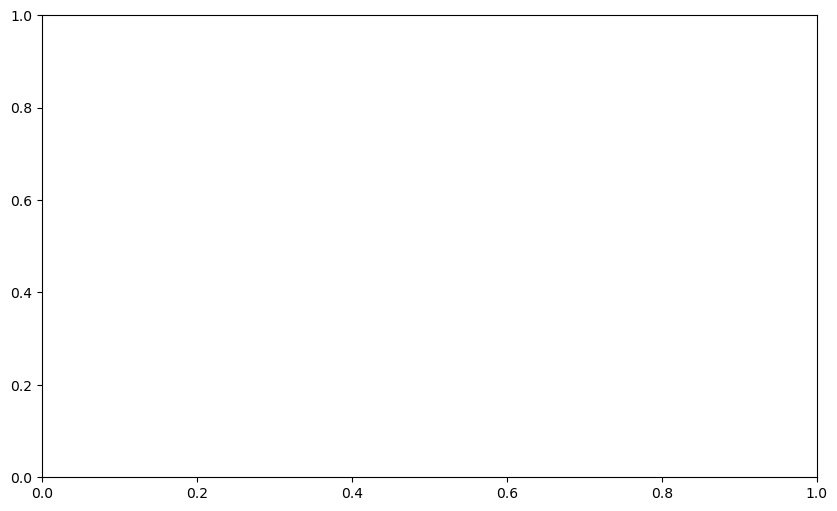

In [ ]:
winter_months = [11, 12, 1, 2, 3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']
data_for_boxplot = []

#monthly_rain_sum_at_site_era5_4km
#monthly_rain_sum_at_site_era5_regridded_31km

for month in winter_months:
    month_4km = monthly_rain_sum_at_site_era5_4km.sel(month=month).values
    month_31km = monthly_rain_sum_at_site_era5_regridded_31km.sel(month=month).values
    month_station=(monthly_sum_by_season_ASOS[month].dropna().values)
    data_for_boxplot.append([month_4km, month_31km, month_station])
    
fig, ax = plt.subplots(figsize=(10, 6))
positions = []
width = 0.6
spacing = 4  

for i, month_data in enumerate(data_for_boxplot):
    pos = [i*spacing + j for j in range(3)]  # 3 boxes per month
    positions.extend(pos)
    bp = ax.bar(0.2, month_data, positions=pos, widths=0.6, patch_artist=True)
    colors = ['green', 'blue', 'black']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

ax.set_xticks([i*spacing + 1 for i in range(len(winter_months))])
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Distribution')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='ERA5 4km'),
                   Patch(facecolor='blue', label='ERA5 31km'),
                   Patch(facecolor='black', label='Station Data PAFA')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


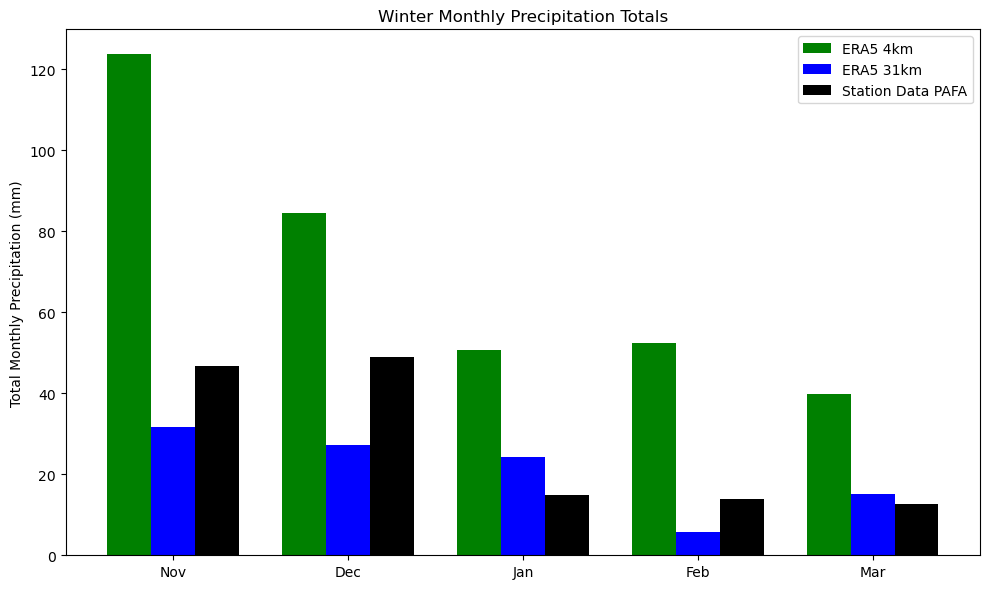

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

winter_months = [11, 12, 1, 2, 3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']

sum_4km = []
sum_31km = []
sum_station = []

for month in winter_months:
    sum_4km.append(
        np.nansum(monthly_rain_sum_at_site_era5_4km.sel(month=month).values)
    )
    sum_31km.append(
        np.nansum(monthly_rain_sum_at_site_era5_regridded_31km.sel(month=month).values)
    )
    sum_station.append(
        sum_order[month])

x = np.arange(len(winter_months))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, sum_4km, width, color='green', label='ERA5 4km')
ax.bar(x,         sum_31km, width, color='blue',  label='ERA5 31km')
ax.bar(x + width, sum_station, width, color='black', label='Station Data PAFA')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Total Monthly Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Totals')
ax.legend()

plt.tight_layout()
plt.show()


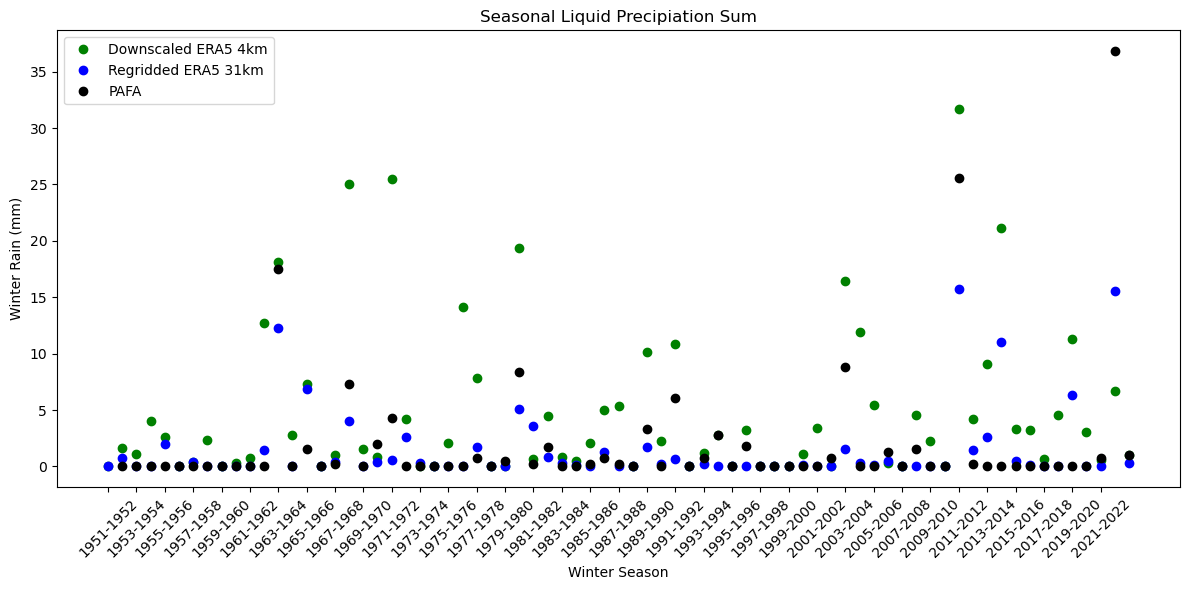

In [ ]:
plt.figure(figsize=(12, 6))
#seasonal_rain_sum_at_site_era5_4km
#seasonal_rain_sum_at_site_era5_regridded_31km
#plt.plot(rick_season_full_df['season'],rick_season_full_df['season_sum_rain_mm'], marker='*',markersize=10, linestyle='', color='purple',label='Local Dataset',zorder=10)
plt.plot(seasons,seasonal_rain_sum_at_site_era5_4km, marker='o',label='Downscaled ERA5 4km', linestyle='', color='green')
plt.plot(seasons,seasonal_rain_sum_at_site_era5_regridded_31km, marker='o', label='Regridded ERA5 31km', linestyle='', color='blue')
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, label='PAFA',marker='o', linestyle='', color='black')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Liquid Precipiation Sum')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2),labels=seasons_seasonal_sum_rain_and_mixed_df[::2],rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
monthly_rain_sum_at_site_era5_4km
monthly_rain_sum_at_site_era5_regridded_31km
monthly_sum_by_season_ASOS

<xarray.DataArray 'rain_ros_sum' (month: 5)> Size: 40B
array([31.77590573, 27.26608882, 24.16420011,  5.69871793, 15.18846333])
Coordinates:
  * month       (month) int64 40B 11 12 1 2 3
    month_name  (month) <U3 60B ...
    XLAT        float32 4B 65.18
    XLONG       float32 4B -148.7

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2299160/2722949440.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))


ValueError: X must have 2 or fewer dimensions

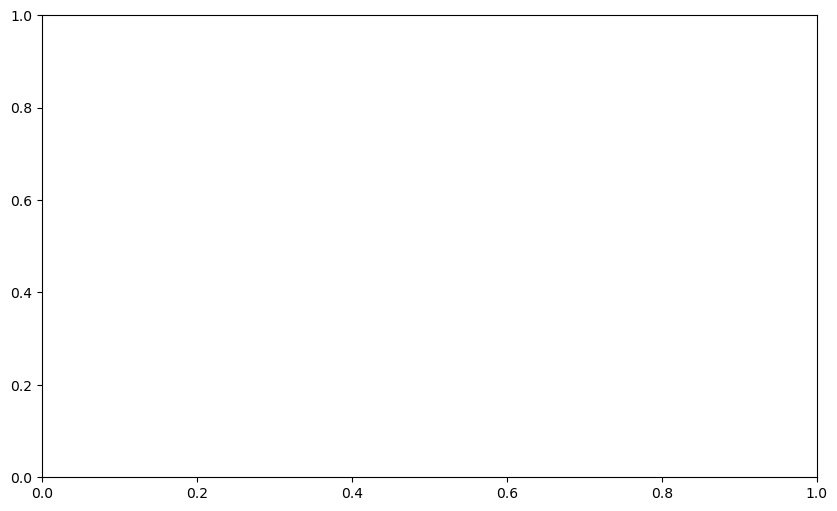

In [ ]:
plt.figure(figsize=(10, 6))
rick_season_full_df_fillnan=rick_season_full_df.fillna(0)
data = [monthly_rain_sum_at_site_era5_4km, monthly_rain_sum_at_site_era5_regridded_31km , monthly_sum_by_season_ASOS]
labels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA']
colors = ['green', 'blue', 'black']
bp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Seasonal Liquid Precipitation Sum Distribution')
plt.ylabel('Winter Rain (mm)')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (21,).

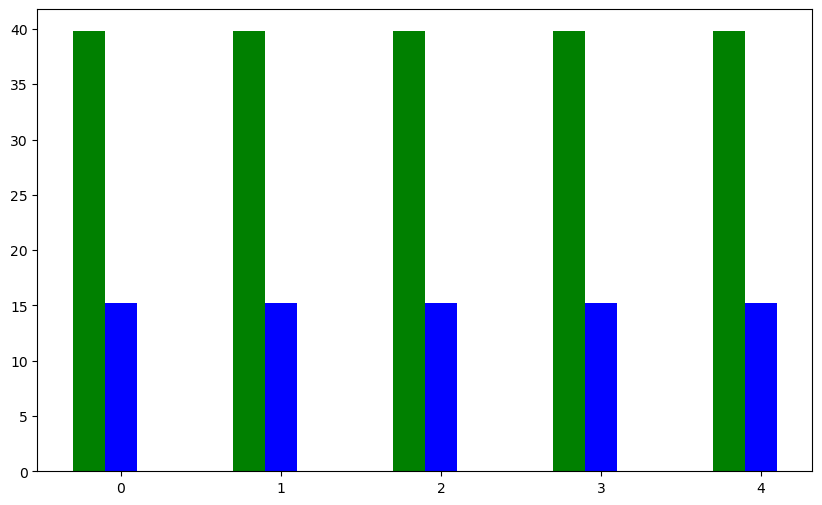

In [ ]:
winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2
x = np.arange(len(winter_months))  # [0,1,2,3,4]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, monthly_rain_sum_at_site_era5_4km.sel(month=month).values, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, monthly_rain_sum_at_site_era5_regridded_31km.sel(month=month).values, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, (monthly_sum_by_season_ASOS[month].dropna().values), width, color='black', label='Station Data PAFA')


ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation Sum (Nov–Mar) Filtered')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [ ]:
'''
plt.figure(figsize=(10, 6))
#seasonal_rain_sum_at_site_era5_4km
#seasonal_rain_sum_at_site_era5_regridded_31km
rick_season_full_df_fillnan=rick_season_full_df.fillna(0)
data = [seasonal_rain_sum_at_site_era5_4km, seasonal_rain_sum_at_site_era5_regridded_31km, seasonal_sum_rain_and_mixed_df,rick_season_full_df_fillnan['season_sum_rain_mm']]
labels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA','Local Data']
colors = ['green', 'blue', 'black', 'purple']
bp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Seasonal Liquid Precipitation Sum Distribution (all years)')
plt.ylabel('Winter Rain (mm)')
plt.show()
'''

"\nplt.figure(figsize=(10, 6))\n#seasonal_rain_sum_at_site_era5_4km\n#seasonal_rain_sum_at_site_era5_regridded_31km\nrick_season_full_df_fillnan=rick_season_full_df.fillna(0)\ndata = [seasonal_rain_sum_at_site_era5_4km, seasonal_rain_sum_at_site_era5_regridded_31km, seasonal_sum_rain_and_mixed_df,rick_season_full_df_fillnan['season_sum_rain_mm']]\nlabels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA','Local Data']\ncolors = ['green', 'blue', 'black', 'purple']\nbp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))\nfor patch, color in zip(bp['boxes'], colors):\n    patch.set_facecolor(color)\nplt.title('Seasonal Liquid Precipitation Sum Distribution (all years)')\nplt.ylabel('Winter Rain (mm)')\nplt.show()\n"

In [ ]:
'''
#monthly_rain_sum_at_site_era5_4km
#monthly_rain_sum_at_site_era5_regridded_31km
winter_months = [11, 12, 1, 2, 3]      
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

sum_asos_vals = monthly_sum_ASOS

rick_vals = rick_monthly

sum_4km_vals = monthly_rain_sum_at_site_era5_4km
sum_31km_vals = monthly_rain_sum_at_site_era5_regridded_31km
x = np.arange(len(winter_months))  # [0,1,2,3,4]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, sum_4km_vals, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, sum_31km_vals, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, sum_asos_vals, width, color='black', label='Station Data PAFA')
ax.bar(x + 2*width, rick_vals, width, color='purple', label='Local Data')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation Sum(Nov–Mar) (All Years)')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()
'''

"\n#monthly_rain_sum_at_site_era5_4km\n#monthly_rain_sum_at_site_era5_regridded_31km\nwinter_months = [11, 12, 1, 2, 3]      \nmonth_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']\nwidth = 0.2\n\nsum_asos_vals = monthly_sum_ASOS\n\nrick_vals = rick_monthly\n\nsum_4km_vals = monthly_rain_sum_at_site_era5_4km\nsum_31km_vals = monthly_rain_sum_at_site_era5_regridded_31km\nx = np.arange(len(winter_months))  # [0,1,2,3,4]\n\nfig, ax = plt.subplots(figsize=(10, 6))\n\nax.bar(x - width, sum_4km_vals, width, color='green', label='Downscaled ERA5 4km')\nax.bar(x, sum_31km_vals, width, color='blue', label='Regridded ERA5 31km')\nax.bar(x + width, sum_asos_vals, width, color='black', label='Station Data PAFA')\nax.bar(x + 2*width, rick_vals, width, color='purple', label='Local Data')\n\nax.set_xticks(x)\nax.set_xticklabels(month_labels)\nax.set_ylabel('Precipitation (mm)')\nax.set_title('Winter Monthly Liquid Precipitation Sum(Nov–Mar) (All Years)')\nax.legend()\nfig.patch.set_alpha(0.0)\nplt.tight

Location
-

In [ ]:
print(cell.XLAT.values, cell.XLONG.values)

64.79339 -147.90959


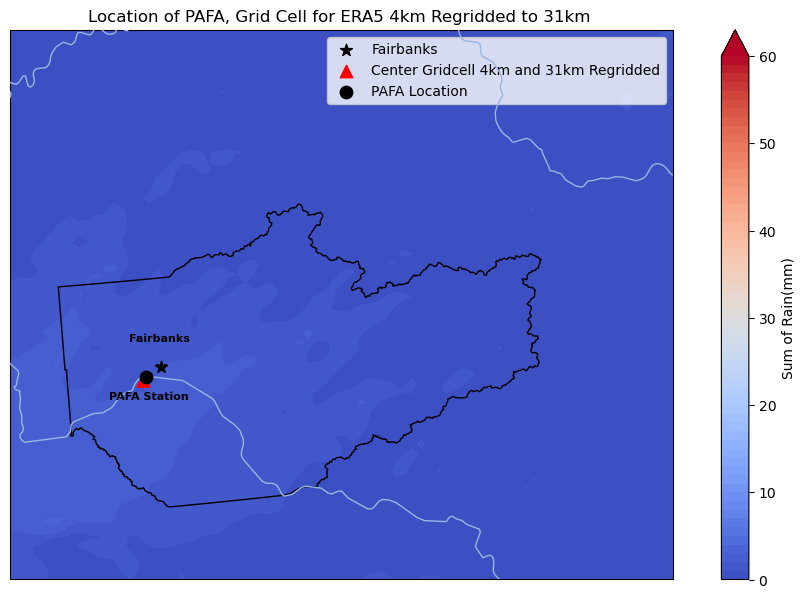

In [ ]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea( central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(era5_4km['XLONG'], era5_4km['XLAT'], np.mean(era5_4km['ros_tally'],axis=(0,1)) , cmap='coolwarm',levels=np.arange(0,61,1), extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Sum of Rain(mm)', ticks=np.arange(0,70,10))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=80,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.1, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.scatter(cell.XLONG.values, cell.XLAT.values,marker='^',s=80,color='red',zorder=10,label='Center Gridcell 4km and 31km Regridded',transform=ccrs.PlateCarree()  )

ax.scatter(pafa_lon, pafa_lat, marker='o', color='black', zorder=10, s=80,label='PAFA Location', transform=ccrs.PlateCarree())
ax.text(pafa_lon, pafa_lat - 0.1, 'PAFA Station',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Location of PAFA, Grid Cell for ERA5 4km Regridded to 31km ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.legend()
plt.tight_layout()
plt.show() 

Only filtering data if its also in Ricks known data??
-

In [ ]:
seasons_in_rick = rick_season_df['season'].unique()
start_year = '1950-1951'
seasons_in_rick = seasons_in_rick[seasons_in_rick >= '1950-1951']
seasons_in_rick=seasons_in_rick[seasons_in_rick<'2022-2023']
seasons_in_rick

array(['1954-1955', '1956-1957', '1960-1961', '1962-1963', '1967-1968',
       '1966-1967', '1970-1971', '1969-1970', '1976-1977', '1979-1980',
       '1981-1982', '1985-1986', '1988-1989', '1992-1993', '1993-1994',
       '1995-1996', '2002-2003', '2001-2002', '2003-2004', '2005-2006',
       '2007-2008', '2010-2011', '2012-2013', '2013-2014', '2014-2015',
       '2015-2016', '2017-2018', '2016-2017', '2018-2019', '2019-2020',
       '2021-2022'], dtype=object)

In [ ]:
monthly_sum_by_season_ASOS_filtered = monthly_sum_by_season_ASOS.loc[seasons_in_rick]
#era5_regridded_31km_rain_sum_at_site
#era5_4km_rain_sum_at_site
monthly_rain_sum_regridded_4km_rain_sum_at_site_filtered = era5_4km_rain_sum_at_site.sel(season=seasons_in_rick)
monthly_rain_sum_raw_rain_sum_at_site_filtered = (era5_regridded_31km_rain_sum_at_site.loc[seasons_in_rick])

In [ ]:
# ASOS
filtered_sum_asos_vals = monthly_sum_by_season_ASOS_filtered[winter_months].sum(axis=0).fillna(0)
# 4km
filtered_sum_4km_vals = monthly_rain_sum_regridded_4km_rain_sum_at_site_filtered.sum(axis=0).reindex(month=winter_months, fill_value=0)
#31km 
filtered_sum_31km_vals = monthly_rain_sum_raw_rain_sum_at_site_filtered.sum(axis=0).reindex(month=winter_months, fill_value=0)
# Local rick data (already filtered)
rick_vals = rick_monthly  # should already only include Nov–Mar data


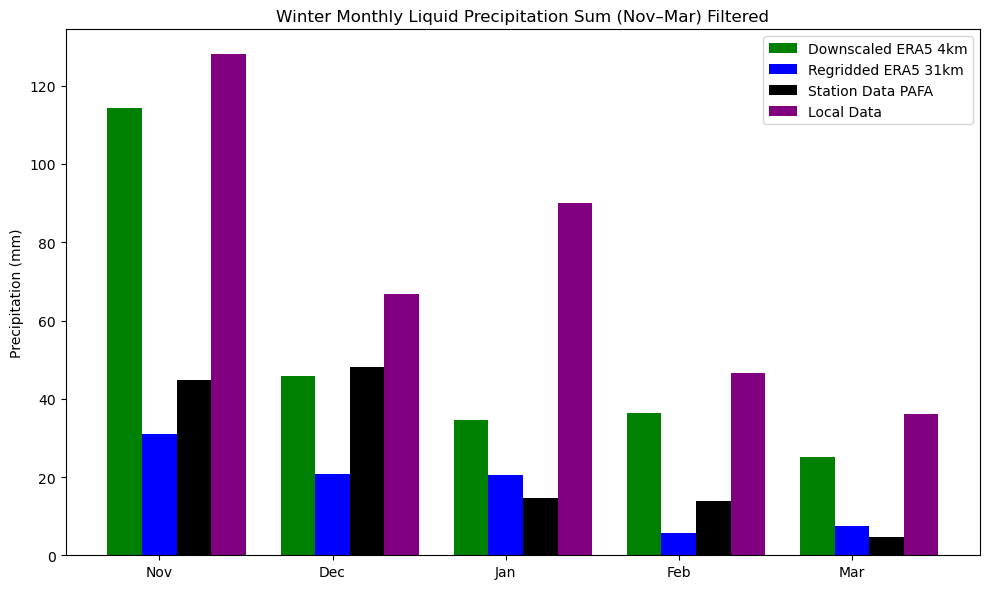

In [ ]:
winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

x = np.arange(len(winter_months))  # [0,1,2,3,4]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, filtered_sum_4km_vals, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, filtered_sum_31km_vals, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, filtered_sum_asos_vals, width, color='black', label='Station Data PAFA')
ax.bar(x + 2*width, rick_vals, width, color='purple', label='Local Data')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Liquid Precipitation Sum (Nov–Mar) Filtered')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [ ]:
# ASOS
filtered_avg_asos_vals = monthly_sum_by_season_ASOS_filtered[winter_months].mean(axis=0).fillna(0)
# 4km
filtered_avg_4km_vals = monthly_rain_sum_regridded_4km_rain_sum_at_site_filtered.mean(axis=0).reindex(month=winter_months, fill_value=0)
#31km 
filtered_avg_31km_vals = monthly_rain_sum_raw_rain_sum_at_site_filtered.mean(axis=0).reindex(month=winter_months, fill_value=0)
# Local rick data (already filtered)

rick_season_df_filled=rick_season_df.fillna(0)
rick_season_df_filled = rick_season_df_filled[rick_season_df_filled['season'].isin(seasons_in_rick)]
rick_monthly_avg = rick_season_df_filled.groupby('Month')['Rain Precip Amount (mm)'].mean(numeric_only=True)

#rick_season_full_df_fillnan=rick_season_full_df.fillna(0)
#rick_monthly_avg=rick_monthly_avg.reindex(winter_months).values #correct order

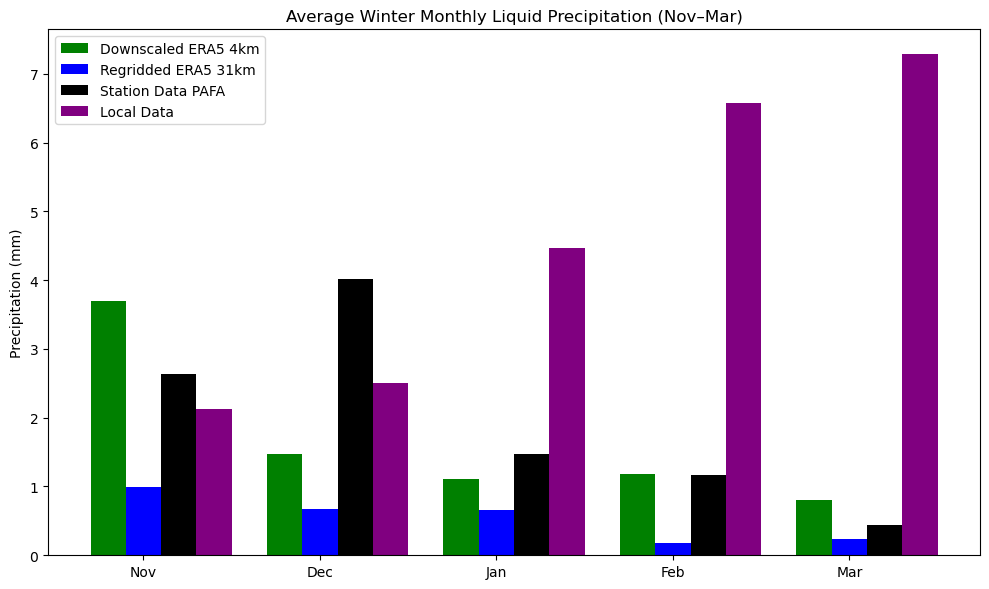

In [ ]:
winter_months = [11, 12, 1, 2, 3]          # months in winter
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar']
width = 0.2

x = np.arange(len(winter_months))  # [0,1,2,3,4]
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, filtered_avg_4km_vals, width, color='green', label='Downscaled ERA5 4km')
ax.bar(x, filtered_avg_31km_vals, width, color='blue', label='Regridded ERA5 31km')
ax.bar(x + width, filtered_avg_asos_vals, width, color='black', label='Station Data PAFA')
ax.bar(x + 2*width, rick_monthly_avg, width, color='purple', label='Local Data')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Average Winter Monthly Liquid Precipitation (Nov–Mar)')
ax.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_3822662/282304022.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))


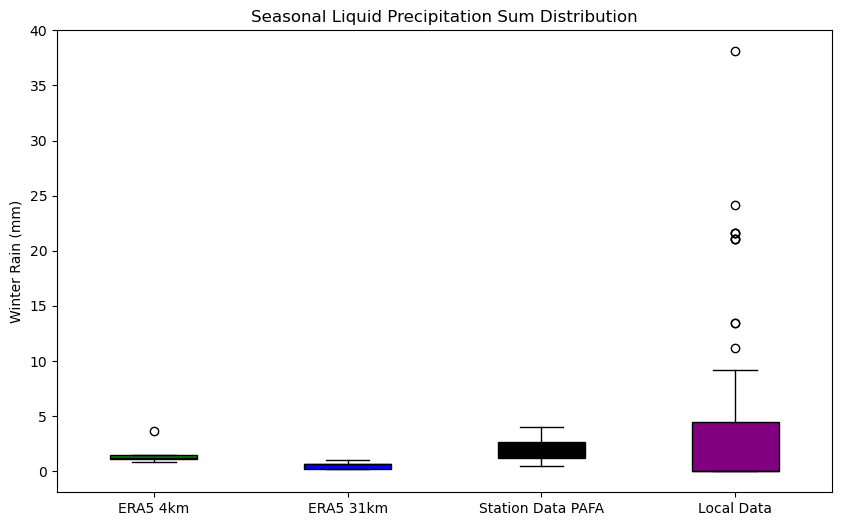

In [ ]:
plt.figure(figsize=(10, 6))
rick_season_full_df_fillnan=rick_season_full_df.fillna(0)
data = [filtered_avg_4km_vals, filtered_avg_31km_vals, filtered_avg_asos_vals,rick_season_full_df_fillnan['season_sum_rain_mm']]
labels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA','Local Data']
colors = ['green', 'blue', 'black', 'purple']
bp = plt.boxplot(data, labels=labels, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Seasonal Liquid Precipitation Sum Distribution')
plt.ylabel('Winter Rain (mm)')
plt.show()

Correlation between Downscaled ERA5 4km and Regridded ERA5 31km: r = 0.81, p = 0.100
Correlation between Downscaled ERA5 4km and Station Data PAFA: r = 0.45, p = 0.446
Correlation between Downscaled ERA5 4km and Local Data: r = 0.86, p = 0.059
Correlation between Regridded ERA5 31km and Downscaled ERA5 4km: r = 0.81, p = 0.100
Correlation between Regridded ERA5 31km and Station Data PAFA: r = 0.66, p = 0.224
Correlation between Regridded ERA5 31km and Local Data: r = 0.94, p = 0.016
Correlation between Station Data PAFA and Downscaled ERA5 4km: r = 0.45, p = 0.446
Correlation between Station Data PAFA and Regridded ERA5 31km: r = 0.66, p = 0.224
Correlation between Station Data PAFA and Local Data: r = 0.45, p = 0.444
Correlation between Local Data and Downscaled ERA5 4km: r = 0.86, p = 0.059
Correlation between Local Data and Regridded ERA5 31km: r = 0.94, p = 0.016
Correlation between Local Data and Station Data PAFA: r = 0.45, p = 0.444


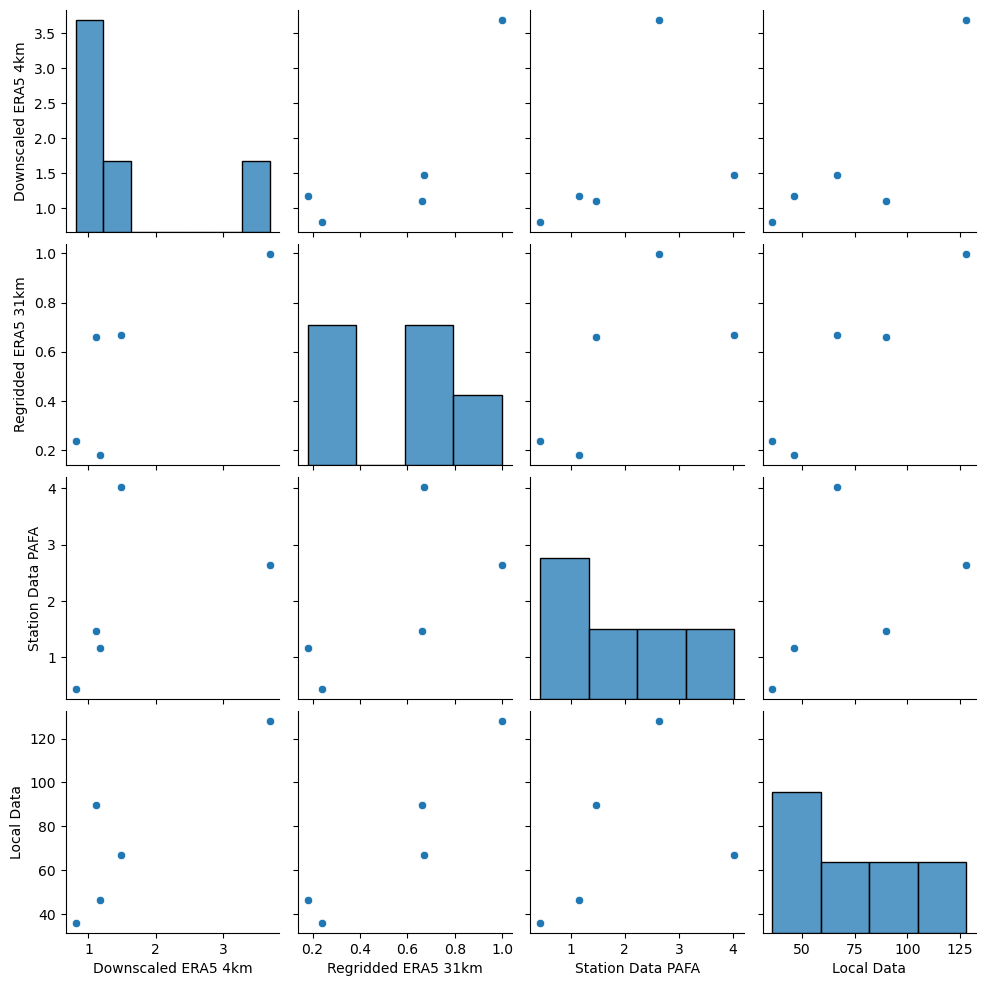

In [ ]:
from scipy.stats import pearsonr
import seaborn as sns
datasets = {
    'Downscaled ERA5 4km': filtered_avg_4km_vals,
    'Regridded ERA5 31km': filtered_avg_31km_vals,
    'Station Data PAFA': filtered_avg_asos_vals,
    'Local Data': rick_vals}

for name1, vals1 in datasets.items():
    for name2, vals2 in datasets.items():
        if name1 != name2:
            r, p = pearsonr(vals1, vals2)
            print(f"Correlation between {name1} and {name2}: r = {r:.2f}, p = {p:.3f}")

df = pd.DataFrame(datasets)
sns.pairplot(df)
plt.show()